<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/TimeSeries/4023_4_15_Nbeats_pytorch_ver2%2C0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Thanks https://www.kaggle.com/code/masatomurakawamm/n-beats-dnn-for-univariate-time-series-forecast

In [11]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zhengjingma","key":"32f5312266b44637b025bcf4faa2e35d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c tabular-playground-series-sep-2022

  0% 0.00/615k [00:00<?, ?B/s]
100% 615k/615k [00:00<00:00, 152MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('tabular-playground-series-sep-2022.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [14]:
## Parameters
data_config = {
    'train.csv': '/content/train.csv',
    'test.csv': '/content/test.csv',
    'sample_submission.csv': '/content/sample_submission.csv',
}

exp_config = {
    'competition_name': 'tps-sep-2022',
    'history_period': 60,  ## Lookback period (days)
    'horizon_period': 30,  ## Forecast period (days)
    'val_ratio': 0.2,  ## Train-vaild split ratio
    'batch_size': 512,
    'train_epochs': 10,
    'learning_rate': 5e-3,
    'gamma': 0.95,  ## parameter of learning scheduler
    'train_limit': True,  ## Use or not the data before 2020
    'checkpoint_filepath': './tmp/model/checkpoint.cpt',
    'finalize': True,  ## For the model finalization
    'finalize_epochs': 5,  ## None or int
    'finalized_filepath': './tmp/model/finalized.cpt',
}

model_config = {
    'emb_dim': 6,  ## categorical features' representation dim
    'n_blocks': 2,  ## number of N-BEATS blocks in a stack
    'n_stacks': 4,  ## number of N-BEATS stacks
    'width': 32,  ## hidden dim in N-BEATS
}

print('Parameters setted!')

Parameters setted!


In [12]:
## Import dependencies 
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os, sys, pathlib, gc
import re, math, random, time
import datetime as dt
from tqdm import tqdm
from typing import Optional, Union, Tuple
from collections import OrderedDict

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

print('import done!')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


import done!


In [26]:
## Data Loading
train_df = pd.read_csv(data_config['train.csv'])
test_df = pd.read_csv(data_config['test.csv'])
submission_df = pd.read_csv(data_config['sample_submission.csv'])

print(f'train_length: {len(train_df)}')
print(f'test_lenght: {len(test_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 70128
test_lenght: 17520
submission_length: 17520


In [27]:
## Null Value Check
print('train_df.info()'); print(train_df.info(), '\n')
print('test_df.info()'); print(test_df.info(), '\n')

## train_df Check
train_df.head()

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB
None 

test_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   date     17520 non-null  object
 2   country  17520 non-null  object
 3   store    17520 non-null  object
 4   product  17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB
None 



,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [28]:
## Features and Targets
original_features = ['date', 'country', 'store', 'product']
target = 'num_sold'

## Number of unique values in each features.
n_unique_features = {feature: train_df[feature].nunique() for feature in original_features}
n_unique_features

{'date': 1461, 'country': 6, 'store': 2, 'product': 4}

In [29]:
## Statistics of num_sold
train_df['num_sold'].describe()

count    70128.000000
mean       194.296986
std        126.893874
min         19.000000
25%         95.000000
50%        148.000000
75%        283.000000
max        986.000000
Name: num_sold, dtype: float64

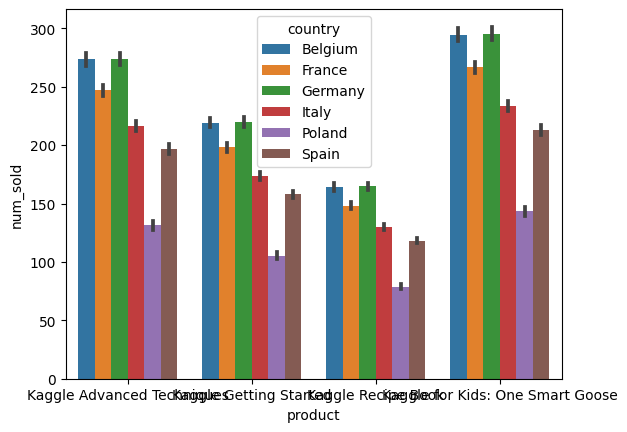

In [30]:
## num_sold of each product in each country
ax = sns.barplot(data=train_df, x='product', y='num_sold', hue='country')

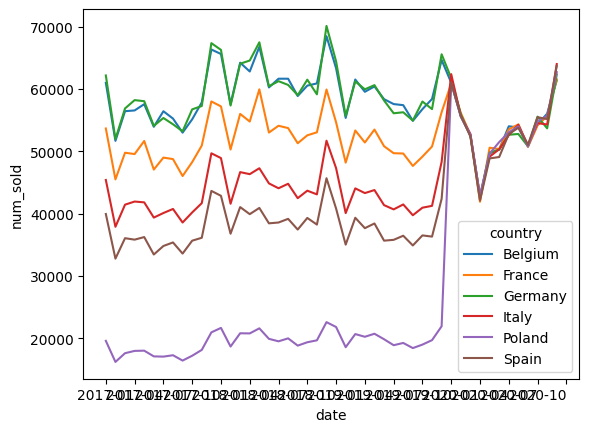

In [31]:
## Total sells by Country
train_df['date'] = pd.to_datetime(train_df['date'])

ax = sns.lineplot(
    data=train_df.groupby([
        train_df.date.dt.strftime('%Y-%m'),
        train_df.country
    ])['num_sold'].sum().reset_index(),
    x='date',
    y='num_sold',
    hue='country',
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

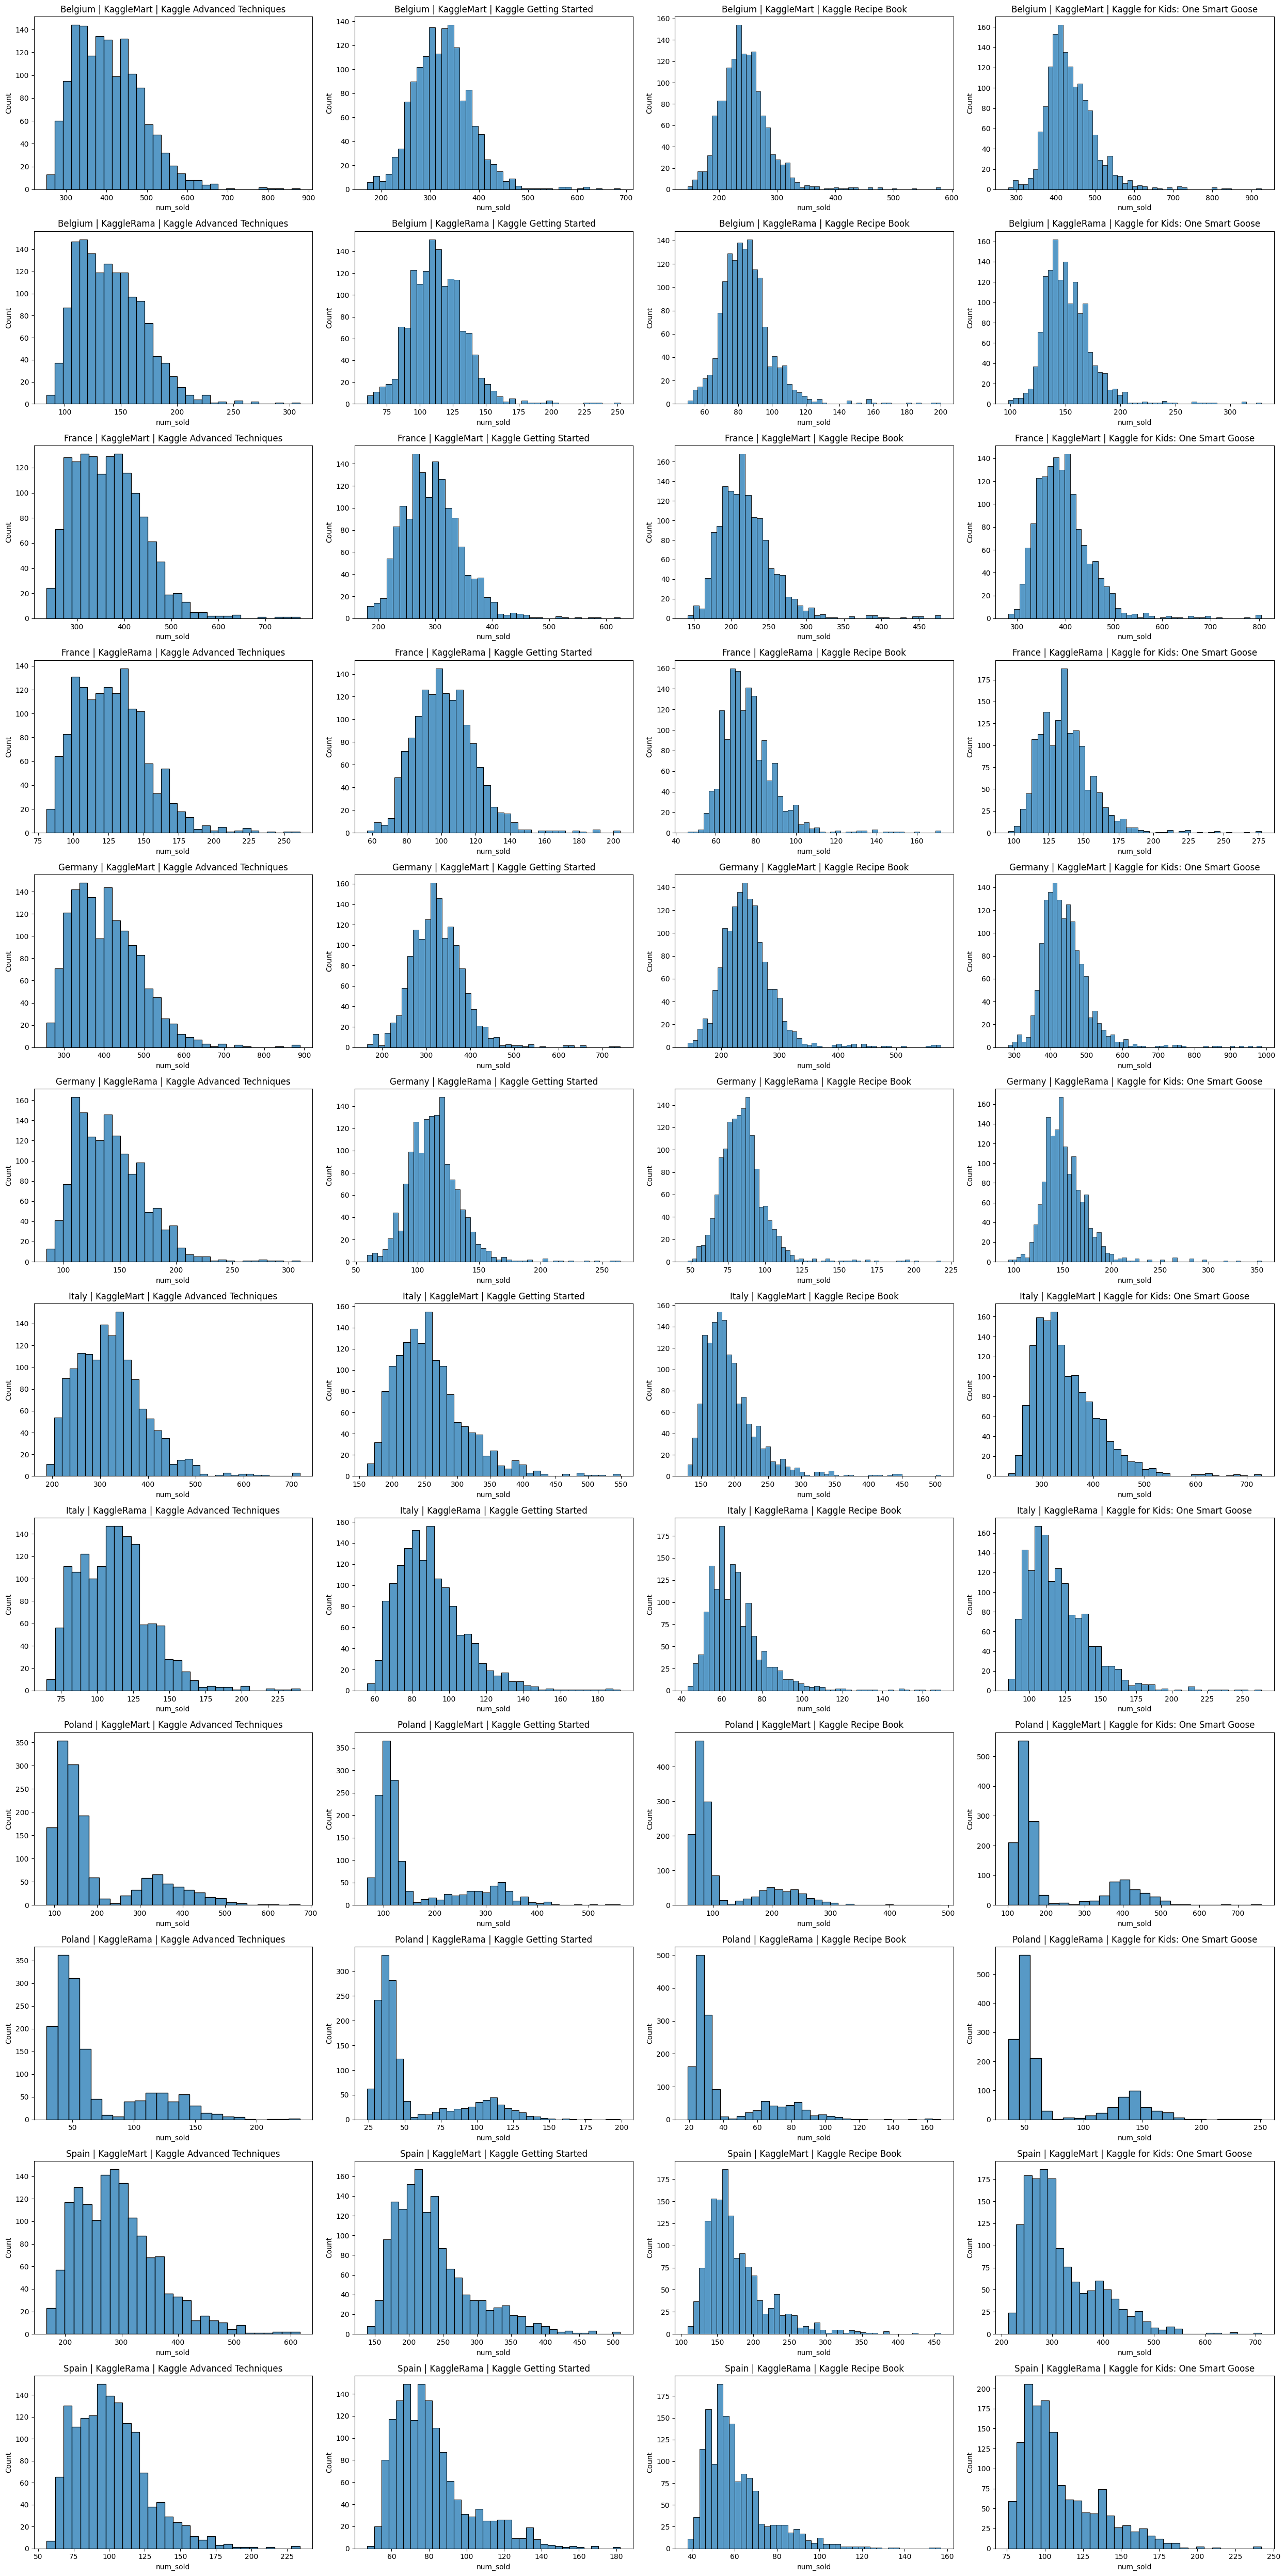

In [32]:
## Distrubutions of num_sold
fig, ax = plt.subplots(12, 4, figsize=(25, 50))
ax = ax.flatten()

for i, (combination, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    sns.histplot(df.num_sold, ax=ax[i])
    ax[i].set_title(' | '.join(combination))
    
plt.tight_layout()

In [33]:
## Datetime Feature Engineering
def date_feature_eng(df, date_column_name, drop=True):
    df[date_column_name] = pd.to_datetime(df[date_column_name])
    df['year'] = df[date_column_name].dt.year
    df['month'] = df[date_column_name].dt.month
    df['day'] = df[date_column_name].dt.day
    df['dayofweek'] = df[date_column_name].dt.dayofweek
    
    if drop:
        df = df.drop(date_column_name, axis=1)
        
    return df

## Create date-related features
train_df = date_feature_eng(train_df, 'date')
test_df = date_feature_eng(test_df, 'date')

## Use or not the data before 2020
if exp_config['train_limit']:
    train_df = train_df[train_df['year']==2020]
    train_df = train_df.reset_index(drop=True)

In [23]:
train_df.head()

,row_id,country,store,product,num_sold,year,month,day,dayofweek
0,52560,Belgium,KaggleMart,Kaggle Advanced Techniques,501,2020,1,1,2
1,52561,Belgium,KaggleMart,Kaggle Getting Started,404,2020,1,1,2
2,52562,Belgium,KaggleMart,Kaggle Recipe Book,362,2020,1,1,2
3,52563,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,536,2020,1,1,2
4,52564,Belgium,KaggleRama,Kaggle Advanced Techniques,174,2020,1,1,2


In [65]:
test_df

,row_id,country,store,product,year,month,day,dayofweek
0,70128,0,0,0,2021,0,0,4
1,70129,0,0,1,2021,0,0,4
2,70130,0,0,2,2021,0,0,4
3,70131,0,0,3,2021,0,0,4
4,70132,0,1,0,2021,0,0,4
...,...,...,...,...,...,...,...,...
17515,87643,5,0,3,2021,11,30,4
17516,87644,5,1,0,2021,11,30,4
17517,87645,5,1,1,2021,11,30,4
17518,87646,5,1,2,2021,11,30,4


In [34]:
## Standardization of numerical featurs and target

## Only 'num_sold' is numerical in this data set
train_num_sold = train_df['num_sold'].values
train_num_sold = train_num_sold.reshape(-1, 1)

## Using sklearn.preprocessing.StandardScaler
sc = StandardScaler()
sc.fit(train_num_sold)
print('StandardScaler mean: ', sc.mean_)
print('StandardScaler scale: ', sc.scale_)

## Check
train_df['num_sold'] = sc.transform(train_num_sold)
train_df['num_sold'].describe()

StandardScaler mean:  [219.44404599]
StandardScaler scale:  [127.00154427]


count    1.756800e+04
mean     1.617811e-17
std      1.000028e+00
min     -1.373558e+00
25%     -8.381319e-01
50%     -3.656967e-01
75%      8.409815e-01
max      4.279916e+00
Name: num_sold, dtype: float64

In [35]:
## Making Lookup table of categorical featurs and target
numerical_columns = ['num_sold']
categorical_columns = ['country', 'store', 'product', 'month', 'day', 'dayofweek']
## I will not use 'year' as a categorical feature.
## Because there are no overlapping in 'year' feature between train and test data.
## It means that the model can't learn the embedding of year==2021.

## Using sklearn.preprocessing.OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='error',
                    dtype=np.int64)
encoded = oe.fit_transform(train_df[categorical_columns].values)
#decoded = oe.inverse_transform(encoded)
train_df[categorical_columns] = encoded
test_df[categorical_columns] = oe.transform(test_df[categorical_columns].values)

## Check
encoder_categories = oe.categories_
encoder_categories

[array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
       dtype=object),
 array(['KaggleMart', 'KaggleRama'], dtype=object),
 array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
        'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
       dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object)]

# Dataset

In [36]:
train_data = train_df.copy()

## Settings
n_country = 6
n_store = 2
n_product = 4
n_items = n_country * n_store * n_product ## 48
n_days = int(len(train_data) / n_items) ## 1461

history_period = exp_config['history_period']  ## Lookback period
horizon_period = exp_config['horizon_period']  ## Forecast period
before_start_idx = n_items * history_period
after_end_idx = n_items * horizon_period

## Helper Functions
def collect_past_data(idx, period, n_items) -> list:
    if idx < n_items * period:
        return []
    past_start_idx = idx - n_items * period
    past_data_ids = [i * n_items + past_start_idx for i in range(period)]
    return past_data_ids

def collect_future_data(idx, period, n_items) -> list:
    future_data_ids = [i * n_items + idx for i in range(period)]
    return future_data_ids

## Operation Check
a = 10000
b = collect_past_data(a, history_period, n_items)
c = collect_future_data(a, horizon_period, n_items)
print('index example: ', a, '\n')
print('history index: \n', b, '\n')
print('prediction index: \n', c, '\n')

index example:  10000 

history index: 
 [7120, 7168, 7216, 7264, 7312, 7360, 7408, 7456, 7504, 7552, 7600, 7648, 7696, 7744, 7792, 7840, 7888, 7936, 7984, 8032, 8080, 8128, 8176, 8224, 8272, 8320, 8368, 8416, 8464, 8512, 8560, 8608, 8656, 8704, 8752, 8800, 8848, 8896, 8944, 8992, 9040, 9088, 9136, 9184, 9232, 9280, 9328, 9376, 9424, 9472, 9520, 9568, 9616, 9664, 9712, 9760, 9808, 9856, 9904, 9952] 

prediction index: 
 [10000, 10048, 10096, 10144, 10192, 10240, 10288, 10336, 10384, 10432, 10480, 10528, 10576, 10624, 10672, 10720, 10768, 10816, 10864, 10912, 10960, 11008, 11056, 11104, 11152, 11200, 11248, 11296, 11344, 11392] 



In [37]:
## Dataset
class TPSSep22TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, numerical_columns, 
                 categorical_columns,
                 history_period=30,
                 horizon_period=30,
                 n_items=48,
                 target=None):
        self.df = df
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.history_period = history_period
        self.horizon_period = horizon_period
        self.n_items = n_items
        self.target = target
        self.before_start_idx = n_items * history_period
        self.after_end_idx = n_items * horizon_period
        
    def __len__(self):
        return (len(self.df) - self.before_start_idx - self.after_end_idx)
    
    def __getitem__(self, index):
        data = OrderedDict()
        index = index + self.before_start_idx
        
        data['row_id'] = self.df['row_id'][index]
        
        for nc in self.numerical_columns:
            past_data_ids = collect_past_data(
                index,
                self.history_period,
                self.n_items
            )
            x = torch.tensor(
                self.df[nc][past_data_ids].values,
                dtype=torch.float32
            )
            name = 'past_' + nc
            data[name] = x
        
        for cc in self.categorical_columns:
            x = torch.tensor(
                self.df[cc][index],
                dtype=torch.int32
            )
            x = torch.unsqueeze(x, dim=0)
            data[cc] = x
        
        if self.target is not None:
            if index + self.after_end_idx < len(self.df):
                future_data_ids = collect_future_data(
                    index,
                    self.horizon_period,
                    self.n_items
                )
                label = torch.tensor(
                    self.df[self.target][future_data_ids].values,
                    dtype=torch.float32
                )
            else:
                label = torch.tensor(
                    self.df[self.target][index],
                    dtype=torch.float32
                )
            return data, label
        else:
            return data

In [38]:
## train-valid split
if exp_config['train_limit']:
    val_ratio = 0.3
else:
    val_ratio = exp_config['val_ratio']

n_val = int((len(train_data) - before_start_idx - after_end_idx) / n_items * val_ratio) * n_items
n_train = len(train_data) - before_start_idx - after_end_idx - n_val
print(n_train, n_val)

train = train_data[:n_train + before_start_idx].reset_index(drop=True)
valid = train_data[-(n_val + after_end_idx):].reset_index(drop=True)
print(len(train), len(valid))

9312 3936
12192 5376


In [39]:
## Making Dataset
train_ds = TPSSep22TrainDataset(
    train, 
    numerical_columns,
    categorical_columns,
    history_period,
    horizon_period,
    n_items,
    target
)

val_ds = TPSSep22TrainDataset(
    valid,
    numerical_columns,
    categorical_columns,
    history_period,
    horizon_period,
    n_items,
    target
)

## Operation Check
print('length of train_ds: ', len(train_ds))
print('length of val_ds: ', len(val_ds))
index = 0
sample = train_ds.__getitem__(index)
print('\n', sample)

length of train_ds:  7872
length of val_ds:  1056

 (OrderedDict([('row_id', 55440), ('past_num_sold', tensor([2.2169, 1.8311, 1.8311, 2.3429, 2.2327, 1.7760, 1.7760, 1.2248, 1.3114,
        1.7681, 1.7445, 2.1146, 1.3036, 1.5555, 1.4138, 1.2878, 1.7288, 1.7366,
        1.9965, 1.2878, 1.4611, 1.2800, 1.6815, 1.6500, 1.8311, 1.9099, 1.3981,
        1.4689, 1.3114, 1.5477, 1.7130, 2.0516, 2.0673, 1.4768, 1.5634, 1.4768,
        1.5634, 1.7130, 2.1382, 2.3272, 1.3981, 1.3823, 2.0673, 1.5162, 1.8390,
        2.0910, 2.4532, 1.8075, 1.6028, 1.7681, 2.1225, 1.9335, 2.2484, 2.5634,
        1.9571, 1.3036, 1.7839, 1.6343, 1.7918, 2.4374])), ('country', tensor([0], dtype=torch.int32)), ('store', tensor([0], dtype=torch.int32)), ('product', tensor([0], dtype=torch.int32)), ('month', tensor([2], dtype=torch.int32)), ('day', tensor([0], dtype=torch.int32)), ('dayofweek', tensor([6], dtype=torch.int32))]), tensor([1.7760, 1.3587, 1.3114, 1.2327, 1.3981, 1.4847, 1.9571, 2.1067, 1.2091,
        1.56

In [40]:
## Making DataLoader
batch_size =exp_config['batch_size']

train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

val_dl = torch.utils.data.DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

dl_dict = {'train': train_dl, 'val': val_dl}

## Operation Check
for dl_sample in (train_dl):
    break  
x_sample = dl_sample[0]
y_sample = dl_sample[1]
print('input keys: ', x_sample.keys())
print('label shape: ', y_sample.shape)

input keys:  odict_keys(['row_id', 'past_num_sold', 'country', 'store', 'product', 'month', 'day', 'dayofweek'])
label shape:  torch.Size([512, 30])


# Model

## Preprocessing Model

In [41]:
class Preprocessor(nn.Module):
    def __init__(self, numerical_features,
                 categorical_features, 
                 encoder_categories, emb_dim):
        super().__init__()
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.encoder_categories = encoder_categories
        self.emb_dim = emb_dim
        self.embed_layers = nn.ModuleDict()
        
        for i, categorical in enumerate(categorical_features):
            embedding = nn.Embedding(num_embeddings=len(encoder_categories[i]),
                                     embedding_dim=self.emb_dim,)
            self.embed_layers[categorical] = embedding
            
    def forward(self, x):
        x_nums = []
        for numerical in self.numerical_features:
            x_num = x[numerical]
            x_nums.append(x_num)
        if len(x_nums) > 0:
            x_nums = torch.cat(x_nums, dim=1)
        else:
            x_nums = torch.tensor(x_nums, dtype=torch.float32)
        
        x_cats = []
        for categorical in self.categorical_features:
            x_cat = self.embed_layers[categorical](x[categorical])
            x_cats.append(x_cat)
        if len(x_cats) > 0:
            x_cats = torch.cat(x_cats, dim=1)
        else:
            x_cats = torch.tensor(x_cats, dtype=torch.float32)
            
        return x_nums, x_cats

In [42]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fc_b = nn.Linear(width, width, bias=False)
        self.fc_f = nn.Linear(width, width, bias=False)
        self.g_b = nn.Linear(width, input_dim)
        self.g_f = nn.Linear(width, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        theta_b = self.fc_b(x)
        theta_f = self.fc_f(x)
        
        backcast = self.g_b(theta_b)
        forecast = self.g_f(theta_f)
        
        return backcast, forecast

In [43]:
class NBeatsStack(nn.Module):
    def __init__(self, n_blocks, input_dim, output_dim, width):
        super().__init__()
        self.n_blocks = n_blocks
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            block = NBeatsBlock(input_dim, output_dim, width)
            self.blocks.append(block)
            
    def forward(self, x):
        stack_forecast = []
        for i in range(self.n_blocks):
            backcast, forecast = self.blocks[i](x)
            x = x - backcast
            stack_forecast.append(forecast)
        stack_forecast = torch.stack(stack_forecast, axis=-1)
        stack_forecast = torch.sum(stack_forecast, axis=-1)
        stack_residual = x
        return stack_residual, stack_forecast

In [44]:
class NBeatsModel(nn.Module):
    def __init__(self, n_blocks, n_stacks, 
                 input_dim, output_dim, width):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_stacks = n_stacks
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        
        self.stacks = nn.ModuleList()
        for _ in range(n_stacks):
            stack = NBeatsStack(n_blocks, input_dim, output_dim, width)
            self.stacks.append(stack)
            
    def forward(self, x):
        global_forecast = []
        for i in range(self.n_stacks):
            stack_residual, stack_forecast = self.stacks[i](x)
            x = stack_residual
            global_forecast.append(stack_forecast)
        global_forecast = torch.stack(global_forecast, axis=-1)
        global_forecast = torch.sum(global_forecast, axis=-1)
        return global_forecast

In [45]:
## settings for models
emb_dim = model_config['emb_dim']
n_blocks = model_config['n_blocks']
n_stacks = model_config['n_stacks']
input_dim = exp_config['history_period']
output_dim = exp_config['horizon_period']
width = model_config['width']
num_epochs = exp_config['train_epochs']

numerical_features = ['past_num_sold']
categorical_features = ['country', 'store', 'product', 'month', 'day', 'dayofweek']

## Building Models
preprocessor = Preprocessor(
    numerical_features,
    categorical_features,
    encoder_categories,
    emb_dim
)

model = NBeatsModel(
    n_blocks,
    n_stacks,
    input_dim,
    output_dim,
    width
)

## Operation, Parameters and Model Structure Check
x_nums, x_cats = preprocessor(x_sample)
y = model(x_nums)
print('Input shape: ', x_nums.shape)
print('Output shape: ', y.shape)

print('# of Preprocessor parameters: ',\
      sum(p.numel() for p in preprocessor.parameters() if p.requires_grad))
print('# of N-BEATS parameters: ',\
      sum(p.numel() for p in model.parameters() if p.requires_grad))

model

Input shape:  torch.Size([512, 60])
Output shape:  torch.Size([512, 30])
# of Preprocessor parameters:  372
# of N-BEATS parameters:  81104


NBeatsModel(
  (stacks): ModuleList(
    (0-3): 4 x NBeatsStack(
      (blocks): ModuleList(
        (0-1): 2 x NBeatsBlock(
          (fc1): Linear(in_features=60, out_features=32, bias=True)
          (fc2): Linear(in_features=32, out_features=32, bias=True)
          (fc3): Linear(in_features=32, out_features=32, bias=True)
          (fc4): Linear(in_features=32, out_features=32, bias=True)
          (fc_b): Linear(in_features=32, out_features=32, bias=False)
          (fc_f): Linear(in_features=32, out_features=32, bias=False)
          (g_b): Linear(in_features=32, out_features=60, bias=True)
          (g_f): Linear(in_features=32, out_features=30, bias=True)
        )
      )
    )
  )
)

# Training

In [46]:
## Loss Function
criterion = nn.MSELoss()

## Optimizer and Learning Rate Scheduler
learning_rate = exp_config['learning_rate']
gamma = exp_config['gamma']
steps_per_epoch = len(train) // batch_size

params = list(preprocessor.parameters()) + list(model.parameters())
optimizer = torch.optim.Adam(
    params=params,
    lr=learning_rate
)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
#                                                          T_max=num_epochs*steps_per_epoch)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=gamma
)

In [47]:
## Model Save & Load
cpt_filepath = exp_config['checkpoint_filepath']

## Function for Saving Model
def model_save(model, preprocessor,
               optimizer, scheduler, path):
    directory = path.split('/')[:-1]
    directory = '/'.join(directory)
    os.makedirs(directory, exist_ok=True)
    
    ## When you use multi GPUs with DataParallel
    model_to_save = model.module if hasattr(model, "module") else model
    
    checkpoint = {
        "model": model_to_save.state_dict(),
        "preprocessor": preprocessor.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch": torch.get_rng_state(),
        "torch_random": torch.random.get_rng_state(),
    }
    
    if torch.cuda.is_available():
        cuda_random_state = {
            "cuda_random": torch.cuda.get_rng_state(),
            "cuda_random_all": torch.cuda.get_rng_state_all(),
        }
        checkpoint.update(cuda_random_state)
        
    torch.save(checkpoint, path)
    print('Model saved!')

    
## Function for Loading Model
def model_load(model, preprocessor,
               optimizer, scheduler, path):
    checkpoint = torch.load(path) 
    
    ## When you use multi GPUs with DataParallel
    if hasattr(model, "module"):  
        model.module.load_state_dict(checkpoint["model"])
    else:
        model.load_state_dict(checkpoint["model"])
        
    preprocessor.load_state_dict(checkpoint["preprocessor"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    random.setstate(checkpoint["random"])
    np.random.set_state(checkpoint["np_random"])
    torch.set_rng_state(checkpoint["torch"])
    torch.random.set_rng_state(checkpoint["torch_random"])
    
    if torch.cuda.is_available():
        torch.cuda.set_rng_state(checkpoint["cuda_random"])
        torch.cuda.torch.cuda.set_rng_state_all(checkpoint["cuda_random_all"])
        
    print('Model loaded!')

In [48]:
## Function for the Model Training
def train_model(model, preprocessor, dl_dict,
                criterion, optimizer, lr_scheduler,
                num_epochs, cpt_filepath=None,
                finalize=False):
    
    ## Checking usability of GUP
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')
    print('-------Start Training-------')
    model.to(device)
    ## We use preprocessor on CPU
    
    ## training and validation loop
    if finalize:
        phases = ['train']
    else:
        phases = ['train', 'val']
        
    losses = {phase: [] for phase in phases}
    best_val_loss = 100.
    best_epoch = 1
    for epoch in range(num_epochs):
        for phase in phases:
            if phase == 'train':
                preprocessor.train()
                model.train()
            else:
                preprocessor.eval()
                model.eval()
                
            epoch_loss = 0.0 
            
            for data, labels in tqdm(dl_dict[phase]):
                x_nums, x_cats = preprocessor(data)
                
                x_nums = x_nums.to(device)
                labels = labels.to(device)
                
                ## Optimizer Initialization
                optimizer.zero_grad()
                
                ## Forward Processing
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(x_nums)
                    loss = criterion(outputs, labels)
                    
                    ## Backward Processing and Optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr_scheduler.step()
                        
                    epoch_loss += loss.item() * x_nums.size(0)
            
            epoch_loss = epoch_loss / len(dl_dict[phase].dataset)
            losses[phase].append(epoch_loss)
            
            ## Saving the best Model
            if phase == 'val':
                if cpt_filepath is not None:
                    if epoch_loss < best_val_loss:
                        best_epoch = epoch + 1
                        best_val_loss = epoch_loss
                        model_save(
                            model, preprocessor,
                            optimizer, lr_scheduler,
                            cpt_filepath
                        )
            
            ## Displaying results
            print('Epoch {}/{} | {:^5} |  Loss: {:.4f}'.format(epoch+1, num_epochs, phase, epoch_loss ))
            
    if finalize:
    ## Saving finalized Model
        if cpt_filepath is not None:
            model_save(
                model, preprocessor, 
                optimizer, lr_scheduler,
                cpt_filepath
            )
            
    return model, preprocessor, losses, best_epoch

In [49]:
## Function for Plotting Losses
def plot_losses(losses, title=None):
    plt.figure(figsize=(7, 5))
    losses = pd.DataFrame(losses)
    losses.index = [i+1 for i in range(len(losses))]
    ax = sns.lineplot(data=losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title(title)

device: cuda:0
-------Start Training-------


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Epoch 1/10 | train |  Loss: 0.3367


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Model saved!
Epoch 1/10 |  val  |  Loss: 0.0974


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Epoch 2/10 | train |  Loss: 0.1405


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Epoch 2/10 |  val  |  Loss: 0.1148


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch 3/10 | train |  Loss: 0.1491


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Epoch 3/10 |  val  |  Loss: 0.1184


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch 4/10 | train |  Loss: 0.0793


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Model saved!
Epoch 4/10 |  val  |  Loss: 0.0739


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Epoch 5/10 | train |  Loss: 0.0768


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Model saved!
Epoch 5/10 |  val  |  Loss: 0.0710


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch 6/10 | train |  Loss: 0.0777


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch 6/10 |  val  |  Loss: 0.0722


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch 7/10 | train |  Loss: 0.0766


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 7/10 |  val  |  Loss: 0.0729


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch 8/10 | train |  Loss: 0.0760


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 8/10 |  val  |  Loss: 0.0731


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Epoch 9/10 | train |  Loss: 0.0757


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 9/10 |  val  |  Loss: 0.0733


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Epoch 10/10 | train |  Loss: 0.0756


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 10/10 |  val  |  Loss: 0.0733
Model loaded!


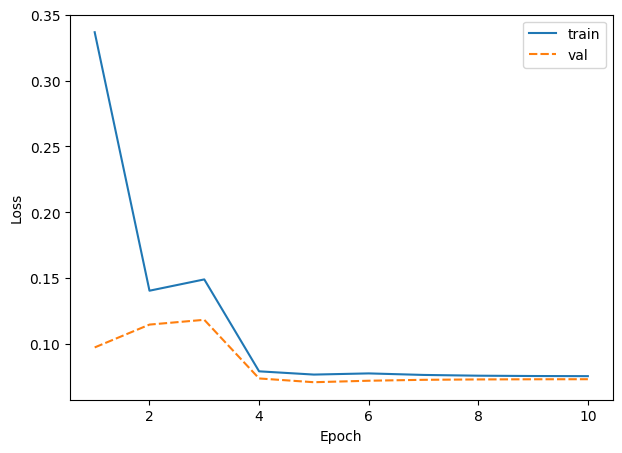

In [50]:
## Training
num_epochs = exp_config['train_epochs']
cpt_filepath = exp_config['checkpoint_filepath']

model, preprocessor, losses, best_epoch = train_model(
    model,
    preprocessor,
    dl_dict,
    criterion,
    optimizer,
    lr_scheduler,
    num_epochs,
    cpt_filepath
)

## Load the Best Model
model_load(
    model,
    preprocessor,
    optimizer,
    lr_scheduler,
    cpt_filepath
)

## Plot Losses
plot_losses(losses)

device: cuda:0
-------Start Training-------


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Epoch 1/5 | train |  Loss: 0.2209


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


Epoch 2/5 | train |  Loss: 0.1025


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Epoch 3/5 | train |  Loss: 0.0836


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


Epoch 4/5 | train |  Loss: 0.0673


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Epoch 5/5 | train |  Loss: 0.0667
Model saved!


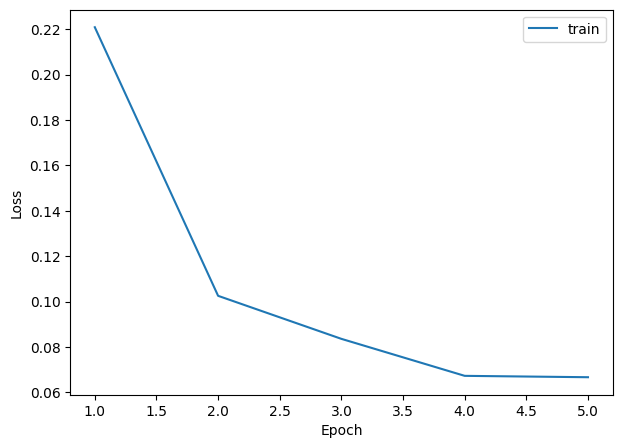

In [51]:
## Finalizing
if exp_config['finalize']:
    
    ## Setting Finalize Epochs
    if exp_config['finalize_epochs'] is not None:
        num_epochs = exp_config['finalize_epochs']
    else:
        num_epochs = best_epoch
    
    ## Making Dataset and DataLoader for Finalizing
    train_all_ds = TPSSep22TrainDataset(
        train_data, 
        numerical_columns,
        categorical_columns,
        history_period,
        horizon_period,
        n_items,
        target
    )
    
    train_all_dl = torch.utils.data.DataLoader(
        train_all_ds,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )
    
    finalize_dl_dict = {'train': train_all_dl}
    
    ## Building Models
    preprocessor = Preprocessor(
        numerical_features,
        categorical_features,
        encoder_categories,
        emb_dim
    )
    
    model = NBeatsModel(
        n_blocks,
        n_stacks,
        input_dim,
        output_dim,
        width
    )
    
    ## Loss Function
    criterion = nn.MSELoss()
    
    ## Optimizer and Learning Rate Scheduler
    learning_rate = exp_config['learning_rate']
    gamma = exp_config['gamma']
    params = list(preprocessor.parameters()) + list(model.parameters())
    optimizer = torch.optim.Adam(
        params=params,
        lr=learning_rate
    )
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
        optimizer,
        gamma=gamma
    )
    
    ## Model Training
    finalized_filepath = exp_config['finalized_filepath']
    
    model, preprocessor, losses, _ = train_model(
        model,
        preprocessor,
        finalize_dl_dict,
        criterion,
        optimizer,
        lr_scheduler,
        num_epochs,
        finalized_filepath,
        finalize=True
    )
    
    ## Plot losses
    plot_losses(losses)

# 6. Prediction

In [52]:
## Dataset for Test Data
class TPSSep22TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_df, train_df,
                 numerical_columns, 
                 categorical_columns,
                 history_period=30,
                 horizon_period=30,
                 n_items=48):
        self.train_df = train_df
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.history_period = history_period
        self.horizon_period = horizon_period
        self.n_items = n_items
        self.before_start_idx = n_items * history_period
        self.after_end_idx = n_items * horizon_period
        
        last_train_data = self.train_df.iloc[-self.before_start_idx:]
        self.test_df = pd.concat([last_train_data, test_df], axis=0, ignore_index=True)
        
    def __len__(self):
        return (len(self.test_df) - self.before_start_idx) // self.after_end_idx + 1
    
    def __getitem__(self, index):
        data = {}
        index = (index * self.after_end_idx + self.before_start_idx)
        
        for i in range(self.n_items):
            item_index = index + i
            data[str(i)] = {}
            data[str(i)]['row_id'] = item_index
            
            past_data_ids = collect_past_data(item_index,
                                              self.history_period,
                                              self.n_items)
            x = torch.tensor(self.test_df['num_sold'][past_data_ids].values,
                             dtype=torch.float32)
            data[str(i)]['history'] = x

        return data
        
    def update(self, new_data, column, row_id):
        row_ids = collect_future_data(row_id,
                                      self.horizon_period,
                                      self.n_items)
        max_id = self.test_df.iloc[-1]['row_id']
        if row_ids[-1] <= max_id:
            self.test_df.loc[self.test_df['row_id'].isin(row_ids), column] = new_data
        else:
            row_ids = np.array(row_ids)
            max_len = (row_ids <= max_id).sum()
            row_ids = row_ids[:max_len]
            
            row_ids = row_ids.tolist()
            new_data = new_data[:max_len]
            self.test_df.loc[self.test_df['row_id'].isin(row_ids), column] = new_data

In [53]:
## Making Test Dataset
test_data = test_df.copy()
test_ds = TPSSep22TestDataset(
    test_data,
    train_data,
    numerical_columns,
    categorical_columns,
    history_period,
    horizon_period,
    n_items
)

## Making Test DataLoader
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    drop_last=False
)

## Operation Check
print('length of test_ds: ', len(test_ds), '\n')
index = 0
test_sample = test_ds.__getitem__(index)
print('number of keys in test data: ', len(test_sample.keys()))
for key in test_sample.keys():
    print('row_id sample: ', test_sample[key]['row_id'])
    print('history sample shape: ', test_sample[key]['history'].shape)
    break

length of test_ds:  13 

number of keys in test data:  48
row_id sample:  2880
history sample shape:  torch.Size([60])


In [54]:
## Function for the Test Data Prediction
def model_predict(model, preprocessor, test_dl):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')
    print('-------Start Prediction-------')
    model.to(device)
    
    preprocessor.eval()
    model.eval()
    
    for data_set in tqdm(test_dl):
        for i in range(n_items):
            data = data_set[str(i)]
            row_id = data['row_id'].item()
            row_id = row_id + test_dl.dataset.test_df['row_id'][0]
            x_nums = data['history']
            x_nums = x_nums.to(device)
            
            with torch.no_grad():
                outputs = model(x_nums)
                outputs = torch.squeeze(outputs)
                outputs = outputs.to('cpu').detach().numpy().copy()
                
            test_dl.dataset.update(outputs, 'num_sold', row_id)
            
    outputs = test_dl.dataset.test_df['num_sold']
    return outputs

In [55]:
## Prediction
outputs = model_predict(model, preprocessor, test_dl)
preds_normed = outputs.iloc[test_dl.dataset.before_start_idx:]

## post-processing
preds = (preds_normed * sc.scale_) + sc.mean_
submission_df['num_sold'] = preds.values
submission_df.to_csv('submission_cv.csv', index=False)

## Check
print('The number of null values: \n', submission_df.isnull().sum())
submission_df.head(10)

device: cuda:0
-------Start Prediction-------


100%|██████████| 13/13 [00:02<00:00,  4.85it/s]


The number of null values: 
 row_id      0
num_sold    0
dtype: int64


,row_id,num_sold
0,70128,370.230326
1,70129,345.400424
2,70130,278.523167
3,70131,426.737360
4,70132,124.138218
5,70133,118.899065
6,70134,96.692831
7,70135,145.145693
8,70136,369.662630
9,70137,342.202732
